In [2]:
import torch

In [3]:
from comet_ml import Experiment, Optimizer

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [5]:
import node

In [6]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [7]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [8]:
from sklearn.metrics import classification_report, balanced_accuracy_score

In [9]:
import pyhopper

In [10]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [11]:
import seaborn as sns

In [12]:
DEVICE="cuda:0"

In [13]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

2

In [14]:
GS_METRIC = ''

# Load data

In [15]:
DATA = "Ionosphere"

In [16]:
if DATA == "Ionosphere":
    ionosphere = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data', header=None)
    ionosphere = ionosphere.drop(1, axis=1)
    X = ionosphere.values[:, :-1].astype(float)
    y = ionosphere.values[:, -1]
    y = LabelEncoder().fit_transform(y).astype(int)
    #(351, 33) 2
    GS_METRIC = "balanced_accuracy"
    
elif DATA == "Libras":
    libras = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data', header=None)
    X = libras.values[:, :-1].astype(float)
    y = libras.values[:, -1].astype(int)
    y -= 1
    #(360, 90) 15
    GS_METRIC = "balanced_accuracy"
    
elif DATA == "Lymphography":
    lymphography = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data', header=None)
    X = lymphography.values[:, 1:].astype(float)
    y = lymphography.values[:, 0].astype(int)
    y -= 1
    #(148, 18) 4
    GS_METRIC = "balanced_accuracy"
    
print(X.shape, len(np.unique(y)))


(702, 33) 2


In [17]:
n_classes = len(np.unique(y))
n_classes

2

In [18]:
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

{0: 252, 1: 450}


In [19]:
n_features = X.shape[1]
n_features

33

In [20]:
max_size = int(len(X)*0.7)

In [21]:
print('dataset size:', len(X), '|', 'max training size:', max_size)

dataset size: 702 | max training size: 645


In [22]:
TEST_RUN = False

# Preprocess

In [23]:
import imblearn
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=100)

## Benchmark

In [25]:
criterion = torch.nn.CrossEntropyLoss()

In [26]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    
    
    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "roc_auc",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if TEST_RUN:
        iters = 1
        
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        print('iter', i+1, 'of', iters, 'X shape', X.shape)
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### Param search

In [27]:
# def grid_search_best_params(model_fn, param_grid, data_size=max_size, scoring=GS_METRIC):
#     if TEST_RUN:
#         tmp = {k: [v[0]] for k, v in param_grid.items()}
#         param_grid = tmp
        
#     X_train, X_test, y_train, y_test = prepare_data(X, y, data_size)

#     cv_clf = GridSearchCV(
#         estimator=model_fn(), 
#         param_grid=param_grid,
#         scoring=scoring, 
#         return_train_score=True,
#         verbose=1, 
#         cv=5,
#     )

#     res = cv_clf.fit(X_train, y_train)

#     print(f'best params for {DATA}', res.best_params_)
#     print('mean_train_score', cv_clf.cv_results_['mean_train_score'].mean())
#     print('std_train_score', cv_clf.cv_results_['std_train_score'].mean())

#     predictions = cv_clf.predict(X_test) 
#     print(classification_report(y_test, predictions))
    
#     with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
#             f.write(str(res.best_params_) + ", " + str(balanced_accuracy_score(y_test, predictions)) + "\n")
    
#     print(f"{DATA}_{model_fn.__name__}_{res.best_params_}")
    
#     return res.best_params_

In [28]:
def pyhopper_best_params(model_fn, param_grid, data_size=max_size, metric=GS_METRIC, time="30m", default_params={}):
    if TEST_RUN:
        time = 60
        
    def objective(params):
    #     print("Training...")
        print('params',params)
        model_results = test_model(
                        model_fn(
                            **default_params,
                            **params
                        ),
                        (X, y),
                        data_size,
                        None, 5)
        with open(f"{DATA}_{model_fn.__name__}_params.txt", "a") as f:
            f.write(str(params) + ", " + str(model_results[model_results["Class"]==metric]["Metric"].mean()) + "\n")
        return model_results[model_results["Class"]==metric]["Metric"].mean()

    from pyhopper.callbacks import History
    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, n_jobs="1x per-gpu", seeding_ratio=0.5)
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    print(f"{DATA}_{model_fn.__name__}_{best_params}")
    return best_params


# TRAIN MODELS

### XGBoost

In [28]:
from xgboost import XGBClassifier

In [29]:
import xgboost
xgboost.__version__

'1.6.0'

In [30]:
def get_xgboost(**params):
    random_seed = np.random.randint(1024)
    def _inner(**args):
        return XGBClassifier(
            verbosity=0,
            random_state=random_seed,
            use_label_encoder=False,
            **params,
            **args
        )
    return _inner    

#### Hyperparam tuning

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.0010000000000000002, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.07100645852761758, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth': 2, 'learning_rate': 0.04676687280062547, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.08831361907268848, 'min_child_weight': 16, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 10, 'learning_rate': 0.02516386136560937, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 250, 'max_depth': 5, 'learning

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 15, 'learning_rate': 0.0009284740000034232, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.0003895413162284106, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.003640728771040827, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 5, 'learning_rate': 0.0021814805935057905, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0013355669608411363, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1450, 'max_depth': 5, '

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.0005379258716072583, 'min_child_weight': 16, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 4.199924327291508e-05, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.00593216033158482, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 2, 'learning_rate': 0.0009058171965027477, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.0003771716177219106, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 3, 'learning_rate': 1.2589278189463621e-05, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.0002745324824085831, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 5, 'learning_rate': 0.0825513476935749, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.009072177459879536, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 1.0979462128048781e-05, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth'

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.0015185643434837582, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.00012729537580989948, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0032081950039551657, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 3.2088174135977124e-05, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.024893506707991037, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_depth':

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 3, 'learning_rate': 0.0001646723035056195, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01039401955036432, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.0001823478828166462, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 1.867961923467007e-05, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 2, 'learning_rate': 0.0006708271140218023, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 15, 'learning_r

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 0.00033871918246736996, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 15, 'learning_rate': 3.8399540999503716e-05, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.02440829307678192, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 9.344061591938453e-05, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1300, 'max_depth': 10, 'learning_rate': 0.0017579280758782466, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 3, 'l

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 3, 'learning_rate': 1.9510087197189462e-05, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.09344920471636062, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 15, 'learning_rate': 0.0035532988204618155, 'min_child_weight': 16, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 15, 'learning_rate': 2.0981346464772864e-05, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.0001429489234576552, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_dep

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 10, 'learning_rate': 0.015445912342264409, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.028517400469204257, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 550, 'max_depth': 5, 'learning_rate': 7.820343465045279e-05, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 10, 'learning_rate': 3.813286422923528e-05, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 10, 'learning_rate': 0.0006782626640182479, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 550, 'max_depth': 3, 'lear

params {'n_estimators': 550, 'max_depth': 10, 'learning_rate': 0.08979732620147224, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.0014183436171525108, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.002582745995248637, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.00010851496147607231, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.0005646316484667813, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 5.288502446116659e-05, 'min_c

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 15, 'learning_rate': 0.02317682289686312, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.04089076806650156, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.020901986345986376, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0001462238680609183, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 3.9385480866208746e-05, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 5, 'learn

iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.002754794666333237, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.005510541731368642, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1300, 'max_depth': 3, 'learning_rate': 0.00198871975316222, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 15, 'learning_rate': 3.8842608598935156e-05, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004464274774851113, 'min_child_weight': 4, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 10, 'learning_rate': 0.

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 3, 'learning_rate': 3.0173846251509982e-05, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.008873235822253535, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 3.9142292974590035e-05, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 2, 'learning_rate': 3.871799371674937e-05, 'min_child_weight': 16, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.0020938265341024303, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 15, 'learning

iter 5 of 5
params {'n_estimators': 550, 'max_depth': 3, 'learning_rate': 2.229714628157088e-05, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01678326084773736, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.00031126581794857164, 'min_child_weight': 16, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.02632214395637953, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.00011188758082895723, 'min_child_weight': 2, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 2, 'learning_rate': 0.00046358831279126925

iter 4 of 5
iter 5 of 5
params {'n_estimators': 1450, 'max_depth': 5, 'learning_rate': 1.5108985406438693e-05, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.0010030488473564171, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.0015936355337151766, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 10, 'learning_rate': 0.00017297143454027237, 'min_child_weight': 4, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1400, 'max_depth': 15, 'learning_rate': 1.7540503442383913e-05, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 2, 'learning_ra

iter 5 of 5
params {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.00029943683692352336, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 1.5108751600573535e-05, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.008100224465726665, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 5, 'learning_rate': 0.0021896397925422716, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.0011173298605702436, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0003250226172

iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'learning_rate': 3.23488159014389e-05, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 1.5762557580120868e-05, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1300, 'max_depth': 3, 'learning_rate': 4.5602274012397877e-05, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.0031029285609196953, 'min_child_weight': 4, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.0003

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 10, 'learning_rate': 0.00013470268473618556, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 4.2557536981986965e-05, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1400, 'max_depth': 10, 'learning_rate': 3.961380256813399e-05, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.019826369551516346, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.002471194533152761, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1450, 'max_depth': 5, 'learning_rat

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.01281976888851803, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.03232302705712211, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 2, 'learning_rate': 0.0010702269091734387, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.001274328705105681, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 15, 'learning_rate': 0.03934426270567778, 'min_child_weight': 16, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 2, 'learning_rate': 1.6

params {'n_estimators': 1450, 'max_depth': 10, 'learning_rate': 0.0005307269775793198, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.03240506803093949, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 2, 'learning_rate': 7.740621803072795e-05, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 9.562011658881477e-05, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 15, 'learning_rate': 0.002216558368285949, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 15, 'learning_rate': 0.015412503323665611, 

params {'n_estimators': 850, 'max_depth': 15, 'learning_rate': 0.004228939182491768, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1450, 'max_depth': 3, 'learning_rate': 3.451579395601432e-05, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.0002607924556690138, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.012077090473012779, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 1.4332648551249734e-05, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth': 10, 'learning_rate': 0.00023185665774306638, 'min

iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.00027014135008699623, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 550, 'max_depth': 15, 'learning_rate': 0.0011553494470213374, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 10, 'learning_rate': 0.00038397414199199567, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 10, 'learning_rate': 0.00021509875748440362, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.028427158328298664, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 2, 'learning_rate': 8

iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.045242206710167696, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 2, 'learning_rate': 0.008122991330615018, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 2, 'learning_rate': 0.0027641603858082815, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0026844174396543, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 6.234640669501973e-05, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.007

iter 5 of 5
params {'n_estimators': 550, 'max_depth': 10, 'learning_rate': 0.0008766708259349105, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 10, 'learning_rate': 0.000679864153929788, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 6.667325562000882e-05, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 10, 'learning_rate': 0.07801425304122837, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 1.1602364489910363e-05, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.006832281972

params {'n_estimators': 950, 'max_depth': 10, 'learning_rate': 8.661028633350442e-05, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 8.33862328113785e-05, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 3, 'learning_rate': 0.0654997235022136, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.0004655981275526622, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.00022167841103157022, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.008510885850270152, 'min_ch

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.02154053366195995, 'min_child_weight': 16, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'learning_rate': 0.05442488979666856, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.000607100328016242, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 2, 'learning_rate': 0.0008217332939413035, 'min_child_weight': 16, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'learning_rate': 0.0148059904674091, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_

iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth': 5, 'learning_rate': 0.00022789763156380003, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.0005184526237375142, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.004452399073153341, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0024433575925680347, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 10, 'learning_rate': 1.3781509017787407e-05, 'min_child_weight': 2, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 15, 'learning_r

iter 5 of 5
params {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 6.526355280040808e-05, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.08726681059413262, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.0020760081921381837, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.09479574869435242, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 15, 'learning_rate': 2.0931068796436453e-05, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth': 5, 'learning_rate': 0.005174090855966051

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 0.0006834853045703242, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 10, 'learning_rate': 0.09330463176673756, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.012800906058111041, 'min_child_weight': 8, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 2, 'learning_rate': 0.004921108410358929, 'min_child_weight': 4, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.00020030287513640306, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 2, 'learning_ra

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 10, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1400, 'max_depth': 10, 'learning_rate': 0.00444546791671833, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 15, 'learning_rate': 0.040955391920680304, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth'

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.015413290653841335, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 15, 'learning_rate': 0.00808434251163844, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.05683342962883044, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05683342962883044, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.07357998726285099, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 15, 'learning_rate': 0.1, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 15, 'learning_rate': 0.1, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 15, 'learning_rate': 0.09026359659810813, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 15, 'learning_rate': 0.09964286181751346, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.009350446421360679, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 15, 'learning_rate': 0.0568

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05683342962883044, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 10, 'learning_rate':

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.046728915492871816, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'learning_rate': 0.1, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 15, 'learning_rate': 0.05683342962883044, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.05521909508767926, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'lea

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 15, 'learning_rate': 0.0009221178907721651, 'min_child_weight': 16, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.06443137113678689, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.1, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 15, 'learning_rate': 0.006545559124367689, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 3, 'learning_

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 16, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.029771294187384622, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 16, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05683342962883044, 'min_child_weight': 4, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 3, 'learning_rate': 0.1, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'learning_rate': 0.00348686406529486, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.024194523316710556, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1300, 'max_depth': 5, 'learning_rate': 0.014936379140364222, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 15, 'learning_rat

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1400, 'max_depth': 15, 'learning_rate': 0.045242806318211905, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth': 15, 'learning_rate': 0.05958922773444426, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 3, 'learning_rate': 0.03465345146165784, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.00539915004592534, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 2

params {'n_estimators': 1050, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.0011011074936817789, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.0008232162318059208, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 32, 'gamma': 0.1

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.1, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 4, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.08137480256025956, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1400, 'max_depth': 2, 'learning_rate': 0.0030163182944639177, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.08555515042960753, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1300, 'max_depth': 3, 'learnin

params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.06655896912943465, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.004562322241718113, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01708472328275726, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.004431796076414949, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 15, 'learning_rate': 0.1, 'min_child_weight': 1, 'gam

iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_depth': 2, 'learning_rate': 0.002960828765829164, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.0011514812801974115, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 550, 'max_depth': 10, 'learning_rate': 0.045192408524486555, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1450, 'max_depth': 15, 'learning_rate': 0.016622722417041127, 'min_child_weight': 

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.0017608081740292112, 'min_child_weight': 1, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1400, 'max_depth': 2, 'learning_rate': 0.06825960418460586, 'min_child_weight': 2, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05683342962883044, 'min_child_weight': 2, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.039287829824752436, 'min_child_weight': 1, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learnin

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.07127190118738767, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.012300726417556392, 'min_child_weight': 4, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 8, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.014266875761579494, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.04296492630352108, 'min_child_weight': 32, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05677290622016

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.1, 'min_child_weight': 32, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.012501349520711502, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_weight': 1, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.1, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1300, 'max_depth': 3, 'learning_rate': 0.0015648614517321622, 'min_child_weight': 2, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.005505593040708179, 'min_child_we

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 3, 'learning_rate': 0.1, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.0007060323413719615, 'min_child_weight': 4, 'gamma': 1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_weight': 8, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 3, 'learning_rate': 0.05046783148227941, 'min_child_weight': 16, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.01786484701641718, 'min_child_weight': 2, 'gamma': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_depth': 5, 'learning_rate': 0.085040483481

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.0007487742565530755, 'min_child_weight': 32, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_depth': 2, 'learning_rate': 0.029658334146717997, 'min_child_weight': 32, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_weight': 8, 'gamma': 0.001}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.001640672064189492, 'min_child_weight': 2, 'gamma': 0.1}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 91.21  : 1     : 2.68 s          
Random seeding    : 

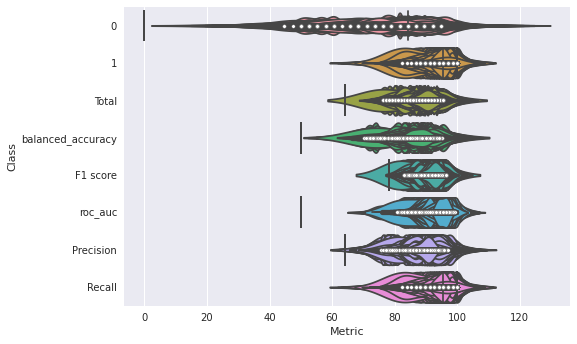

In [31]:
param_grid = {
                'n_estimators': pyhopper.int(50, 1500, multiple_of=50),
                'max_depth': pyhopper.choice([2, 3, 5, 10, 15]),
                'learning_rate': pyhopper.float(1e-5,1e-1, log=True),
                'min_child_weight': pyhopper.choice([1, 2, 4, 8, 16, 32]),
                'gamma': pyhopper.choice([0, 0.001, 0.1, 1]),
             }

xgbt_best1 = pyhopper_best_params(get_xgboost, param_grid, time="90m")

In [32]:
param_grid = {
                'subsample': pyhopper.choice([0.5, 0.6, 0.7, 0.8, 0.9, 1]),
                'reg_lambda': pyhopper.float(1e-5, 10, init=0, log=True),
                'reg_alpha': pyhopper.float(1e-5, 10, init=0, log=True),
             }


xgbt_best2 = pyhopper_best_params(get_xgboost, param_grid, time="90m", default_params=xgbt_best1)

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 0.00041856483879895587, 'reg_alpha': 4.961747421147e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.03970613464979336, 'reg_alpha': 0.04392527039438329}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.0001286788566326914, 'reg_alpha': 0.07578263550134012}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.00308739561892083, 'reg_alpha': 0.10101934510225868}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 1.1203615560426436e-05, 'reg_alpha': 0.00011096069516909638}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 5.3148528641669

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 0.00026423675023068074, 'reg_alpha': 0.00014064973668895042}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.21242668671051407, 'reg_alpha': 1.0500364388389178}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 0.0028212406165129345, 'reg_alpha': 0.0009023232963717795}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 0.1768473477590729, 'reg_alpha': 0.09070138759308072}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.31737296918316216, 'reg_alpha': 0.0026374527194740296}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 2.661165359166721, 'reg_alpha': 0.004356049348746693}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subs

params {'subsample': 0.6, 'reg_lambda': 3.570892633111767e-05, 'reg_alpha': 0.00019675419768349375}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 1.1161742877700576, 'reg_alpha': 0.029062999538065404}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.0001502015213209489, 'reg_alpha': 0.11398376028329543}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.06538197418800235, 'reg_alpha': 1.2612105164281995}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 0.07995858451158262, 'reg_alpha': 2.947464471103299}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 3.1564225621598e-05, 'reg_alpha': 0.00010871288083273802}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 1.1625024106555034e-05, '

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 6.765017660858418e-05, 'reg_alpha': 0.00034285046278110924}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.00011171541152282364, 'reg_alpha': 4.358588969310869e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 3.9227843908788897, 'reg_alpha': 0.2719660507102562}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.0004165722628948339, 'reg_alpha': 1.4035448088942148}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 1.3287496849553726, 'reg_alpha': 0.0007759051973032466}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.01407800072628482, 'reg_alpha': 0.0002905048019717271}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'s

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.12160704809351697, 'reg_alpha': 3.3781283081425455e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 1.2113610221811981, 'reg_alpha': 0.004440607390547104}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 3.5817100802179164e-05, 'reg_alpha': 0.18202574709760033}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.00079593940715667, 'reg_alpha': 9.115188349534519}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.00023441190679838173, 'reg_alpha': 0.5715689025152446}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 0.018922167793484466, 'reg_alpha': 4.127646634840382}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample'

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.00012053453302241671, 'reg_alpha': 0.7048581716398725}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.023500401168940553, 'reg_alpha': 0.012481424850673852}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.0032214672201990096, 'reg_alpha': 0.00017802656028149722}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 0.008186839365502348, 'reg_alpha': 1.4030446001170873}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.5419811660678678, 'reg_alpha': 0.7176875220237736}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.4174858317570959, 'reg_alpha': 0.0067655073467574765}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsa

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.015597180827482491, 'reg_alpha': 0.8772256276100459}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 1.5138137651053385e-05, 'reg_alpha': 0.0039053689820811597}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.0014649850105787952, 'reg_alpha': 0.0006243549910186066}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 2.0635428578270796, 'reg_alpha': 0.0033943078284136173}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 1.1961800745439397e-05, 'reg_alpha': 0.13880100272810775}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.10410425857863696, 'reg_alpha': 0.001623643904691785}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'s

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.019977760525442517, 'reg_alpha': 0.002837402767232712}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.018479732381860143, 'reg_alpha': 6.215585809574629}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.1322819277028293, 'reg_alpha': 1.1816897179999574e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 0.00013706374223949663, 'reg_alpha': 0.0012852864642060556}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 6.866983105532182, 'reg_alpha': 0.043046673423388596}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



params {'subsample': 0.5, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0006630054509671878}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.0005438493747435715, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 1e-05, 'reg_alpha': 0.026758796525345113}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.04208698215053917}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.00010951739968847734, 'reg_alpha': 0.016432270307661395}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 1e-05, 'reg_alpha': 0.0729918797791392}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.02503602459004327, 'reg_alpha': 0.7459824805

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.0015735192216917609, 'reg_alpha': 0.009771611073936587}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 0.000518546750930923, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.0002540935974226244, 'reg_alpha': 0.039614795372915186}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.0003084107621076314, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 1.2166026713189305e-05, 'reg_alpha': 0.0003390839995768113}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.00025736224249728567, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params 

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 0.0010140549404651273, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.0007525840468948506, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.00016353121104035383, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.6, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0005313420893081723}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 3.4279963713298536e-05, 'reg_alpha': 0.008421742141024877}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 9.330334088654781e-05, 'reg_alpha': 0.0010966315186125147}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
par

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.018289253155504136}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 0.00011331354053821676, 'reg_alpha': 5.647666993984924e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.00032811924302604426, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.013259680994860691}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.00025647599846494894}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 1.2398851357818762e-05, 'reg_alpha': 1.2221672272502277e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 3.173841246444812e-05, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.03794172567684232}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.013535662741356874}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 0.30259692232152724}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.000810005029809735}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.02824580973661027, 'reg_alpha': 0.0001993031204119938}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.5, 'reg_lambda': 0.002114800584968955, 'reg_alpha': 0.14204574681947407}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.004464586224888195}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.002137742876718692, 'reg_alpha': 4.577642980134408e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0021463256650086134}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0375117086806541}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0025911283032482}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 5.033830047126576e-05, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 1e-05, 'reg_alpha': 0.008268563666177182}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0003661522527624768}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.7, 'reg_lambda': 0.003312470534925499, 'reg_alpha': 0.03077612516462971}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.0013371486559393977}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.0007253888037764585, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 0.0005054573450654194, 'reg_alpha': 0.00591059230013659}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.003209010206788162}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 0.9, 'reg_lambda': 4.283256437690267e-05, 'reg_alpha': 0.025960291665307646}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'subsample': 1, 'reg_lambda': 1e-05, 'reg_alpha': 2.5371928338488284e-05}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Best Params

'Ionosphere' {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 1500}


In [33]:
xgboost_best = {**xgbt_best1, **xgbt_best2}

iter 1 of 20
iter 2 of 20
iter 3 of 20
iter 4 of 20
iter 5 of 20
iter 6 of 20
iter 7 of 20
iter 8 of 20
iter 9 of 20
iter 10 of 20
iter 11 of 20
iter 12 of 20
iter 13 of 20
iter 14 of 20
iter 15 of 20
iter 16 of 20
iter 17 of 20
iter 18 of 20
iter 19 of 20
iter 20 of 20


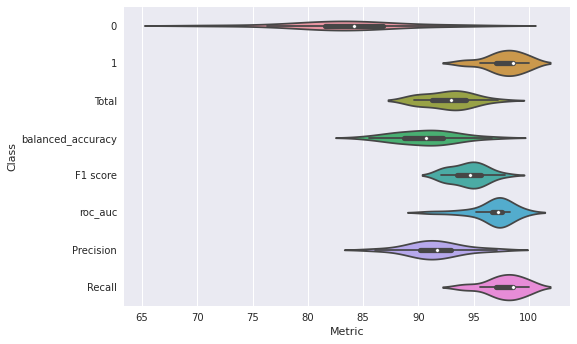

In [34]:
data_size = max_size

xgb_dframe = test_model(get_xgboost(**xgboost_best),
                        (X, y),
                        data_size,
                        label_encoder=None, iters=20)

In [35]:
res = xgb_dframe[xgb_dframe["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

245: 92.69 ~ 2.16 (max: 97.17)


In [36]:
xgb_dframe.groupby(['Class']).mean()

,Metric
Class,
0,83.552632
1,97.794118
F1 score,94.505008
Precision,91.474974
Recall,97.794118
Total,92.688679
balanced_accuracy,90.673375
roc_auc,96.743421


### NODE

In [37]:
from qhoptim.pyt import QHAdam

In [38]:
def node_fn(layer_dim=128, num_layers=1, depth=3):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], 
                            layer_dim=layer_dim,
                            num_layers=num_layers, 
                            tree_dim=n_classes+1, 
                            depth=depth, 
                            flatten_output=False,
                            choice_function=node.entmax15, 
                            bin_function=node.entmoid15
                           ),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train, device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

#### Tune hyperparams

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'layer_dim': 256, 'num_layers': 3, 'depth': 4}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
/home/z1157095/anaconda3/en

iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 2, 'depth': 2}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 128, 'num_layers': 5, 'depth': 6}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 3, 'depth': 3}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 1024, 'num_layers': 2, 'depth': 7}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 5, 'depth': 5}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 256, 'num_layers': 2, 'depth': 7}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 512, 'num_layers': 5, 'depth': 6}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 5, 'depth': 7}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 128, 'num_layers': 5, 'depth': 4}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 5, 'depth': 4}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 5, 'depth': 3}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 3, 'depth': 7}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 4, 'depth': 5}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 3, 'depth': 5}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 128, 'num_layers': 5, 'depth': 7}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


params {'layer_dim': 64, 'num_layers': 5, 'depth': 6}
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 86.19  : 1     : 04:04 (m:s)     
Random seeding    : 91.69  : 7     : 41:27 (m:s)     
Local sampling    : 91.11  : 9     : 40:41 (m:s)     
Duplicates        : -      : 10    : -               
----------------  : ----   : ----  : ----            
Total             : 91.69  : 27    : 01:26:11 (h:m:s)
Ionosphere_node_fn_{'layer_dim': 64, 'num_layers': 5, 'depth': 5}


{'layer_dim': 64, 'num_layers': 5, 'depth': 5}

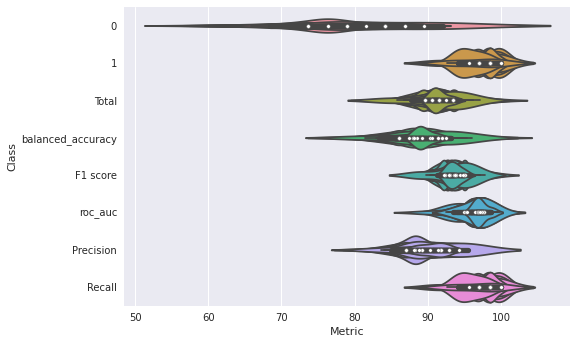

In [39]:
# 'layer_dim': hp.quniform('layer_dim', 100, 1200, 100),
# 'num_layers': hp.quniform('num_layers', 1, 4, 1),
# 'depth': hp.quniform('depth', 2, 7, 1)
                    
param_grid = {
    'layer_dim': pyhopper.int(64, 1024, power_of=2),
    'num_layers': pyhopper.int(1, 5),
    'depth': pyhopper.int(2, 7),
}

node_best = pyhopper_best_params(node_fn, param_grid, time="90m")
node_best

#### Use best hyperparams

In [40]:
%%capture --no-stdout

size=max_size

node_results = test_model(node_fn(**node_best),
                    (X, y),
                    size,
                    label_encoder=None, iters=10)
res = node_results[node_results["Class"]=="roc_auc"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10
245: 97.23 ~ 1.44, (max: 98.84)


### Dropout Neural network

In [41]:
def network_fn1(epochs=100, drop1=0.3, drop2=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(64, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner



def network_fn2(epochs=100, drop1=0.3, drop2=0.5, drop3=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(64, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop3),
                        torch.nn.Linear(64, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner



def network_fn3(epochs=100, drop1=0.3, drop2=0.5, drop3=0.5, drop4=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(64, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop3),
                        torch.nn.Linear(128, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop4),
                        torch.nn.Linear(64, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner

#### Find Hyperparams

### Dropout 1 layer

  0%|          | [00:00<?]

Search is scheduled for 01:00:00 (h:m:s)
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.3, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.7, 'drop2': 0.1, 'lr': 3e-05, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.7, 'drop2': 0.3, 'lr': 0.0003, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.7, 'drop2': 0.5, 'lr': 0.3, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.5, 'drop2': 0.3, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.5, 'drop2': 0.3, 'lr': 0.003, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.7, 'drop2': 0.5, 'lr': 3e-05, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
it

{'epochs': 150, 'drop1': 0.5, 'drop2': 0.1, 'lr': 3e-05, 'batch_size': 64}

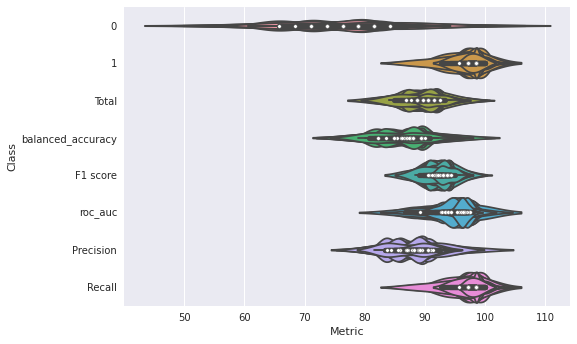

In [42]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn1_best_params = pyhopper_best_params(network_fn1, param_grid, time="60m")
nn_fn1_best_params

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10


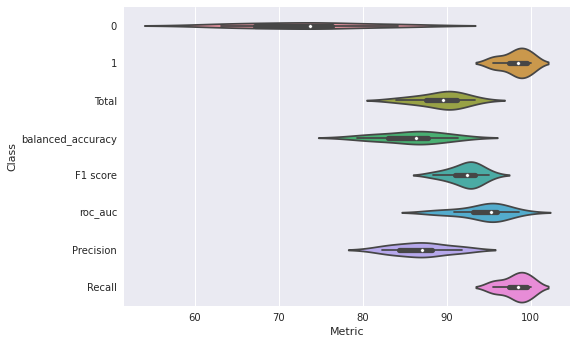

In [43]:
data_size = max_size

nn1_results = test_model(network_fn1(**nn_fn1_best_params),
                (X, y),
                data_size,
                None, 10)

In [44]:
res = nn1_results[nn1_results["Class"]=="Balanced Acc score"]["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

245: nan ~ nan (max: nan)


### Dropout 2 layers

  0%|          | [00:00<?]

Search is scheduled for 01:10:00 (h:m:s)
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.3, 'drop3': 0.3, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.3, 'drop2': 0.3, 'drop3': 0.5, 'lr': 0.03, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.7, 'drop2': 0.1, 'drop3': 0.5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.5, 'drop3': 0.3, 'lr': 0.03, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.1, 'drop3': 0.3, 'lr': 0.03, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.1, 'drop2': 0.7, 'drop3': 0.5, 'lr': 0.03, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'dro

{'epochs': 100,
 'drop1': 0.3,
 'drop2': 0.1,
 'drop3': 0.1,
 'lr': 0.03,
 'batch_size': 32}

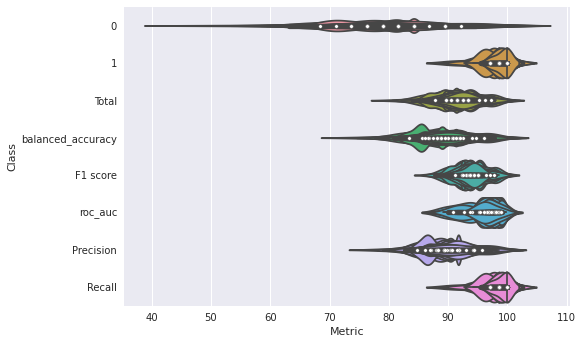

In [45]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop3": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn2_best_params = pyhopper_best_params(network_fn2, param_grid, time="70m")
nn_fn2_best_params

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10


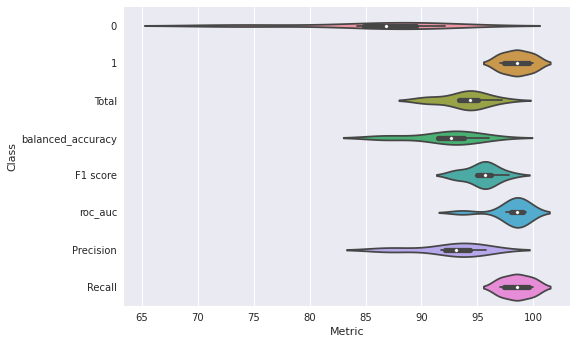

In [46]:
data_size = max_size

nn2_results = test_model(network_fn2(**nn_fn2_best_params),
                (X, y),
                data_size,
                None, 10)

### Dropout 3 layers

  0%|          | [00:00<?]

Search is scheduled for 01:15:00 (h:m:s)
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.3, 'drop3': 0.3, 'drop4': 0.3, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.3, 'drop3': 0.5, 'drop4': 0.5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.3, 'drop2': 0.7, 'drop3': 0.3, 'drop4': 0.7, 'lr': 0.0003, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.3, 'drop2': 0.1, 'drop3': 0.1, 'drop4': 0.5, 'lr': 0.03, 'batch_size': 32}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 100, 'drop1': 0.7, 'drop2': 0.3, 'drop3': 0.3, 'drop4': 0.3, 'lr': 0.003, 'batch_size': 64}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'epochs': 150, 'drop1': 0.5, 'drop2': 0.1, 'drop3': 0.7, 'drop4': 0.3, 'lr': 0.003, 'batch_size': 32}

{'epochs': 150,
 'drop1': 0.1,
 'drop2': 0.3,
 'drop3': 0.3,
 'drop4': 0.1,
 'lr': 0.003,
 'batch_size': 32}

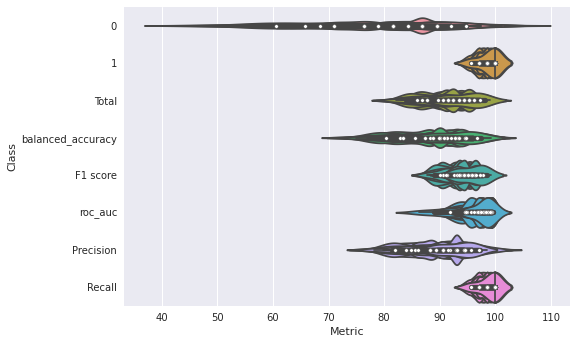

In [47]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop3": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop4": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn3_best_params = pyhopper_best_params(network_fn3, param_grid, time="75m")
nn_fn3_best_params

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10


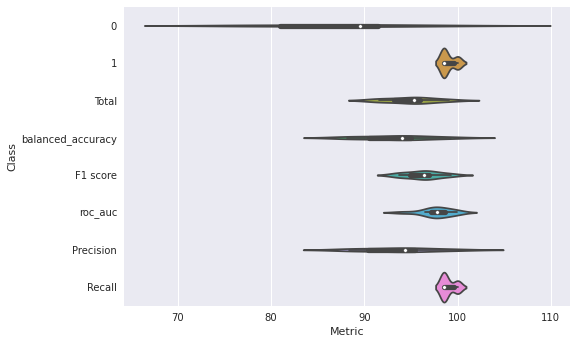

In [48]:
data_size = max_size

nn3_results = test_model(network_fn3(**nn_fn3_best_params),
                (X, y),
                data_size,
                None, 10)

### HypernetworkPCA

In [49]:
def network_pca_fn(epochs=100, masks_no=100, mask_size=100, target_size=100, n_comp=5, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_comp, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=n_features
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=lr)
        return network
    return _inner

In [50]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

In [51]:
X.shape[1] // 7

4

#### Find hyperparams

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'epochs': 100, 'masks_no': 60, 'mask_size': 11, 'target_size': 5, 'n_comp': 9, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
torch.Size([1, 128])
33
iter 2 of 5
torch.Size([1, 128])
33
iter 3 of 5
torch.Size([1, 128])
33
iter 4 of 5
torch.Size([1, 128])
33
iter 5 of 5
torch.Size([1, 128])
33
params {'epochs': 100, 'masks_no': 80, 'mask_size': 3, 'target_size': 5, 'n_comp': 13, 'lr': 0.3, 'batch_size': 32}
iter 1 of 5
torch.Size([1, 128])
33
iter 2 of 5
torch.Size([1, 128])
33
iter 3 of 5
torch.Size([1, 128])
33
iter 4 of 5
torch.Size([1, 128])
33
iter 5 of 5
torch.Size([1, 128])
33
params {'epochs': 100, 'masks_no': 50, 'mask_size': 13, 'target_size': 5, 'n_comp': 9, 'lr': 0.003, 'batch_size': 32}
iter 1 of 5
torch.Size([1, 128])
33
iter 2 of 5
torch.Size([1, 128])
33
iter 3 of 5
torch.Size([1, 128])
33
iter 4 of 5
torch.Size([1, 128])
33
iter 5 of 5
torch.Size([1, 128])
33
params {'epochs': 150, 'masks_no': 90, 'mask_size': 14, 'target_siz

{'epochs': 100,
 'masks_no': 60,
 'mask_size': 11,
 'target_size': 5,
 'n_comp': 9,
 'lr': 3e-05,
 'batch_size': 32}

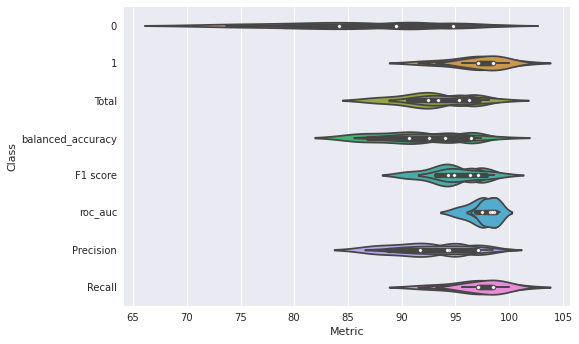

In [52]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.int(10, 100, multiple_of=10),
    "mask_size": pyhopper.int(3, 20),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "n_comp": pyhopper.int(3, 15),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),

}

hp_pca_best_params = pyhopper_best_params(network_pca_fn, param_grid, time="90m")
hp_pca_best_params

In [53]:
hp_pca_best_params

{'epochs': 100,
 'masks_no': 60,
 'mask_size': 11,
 'target_size': 5,
 'n_comp': 9,
 'lr': 3e-05,
 'batch_size': 32}

'Libras'
{'epochs': 150,
 'masks_no': 70,
 'mask_size': 20,
 'target_size': 10,
 'n_comp': 10}

'Lymphography' {'epochs': 120, 'masks_no': 50, 'mask_size': 4, 'target_size': 20, 'n_comp': 6}

In [54]:
DATA

'Ionosphere'

Ionosphere
{'epochs': 100, 'masks_no': 60, 'mask_size': 5, 'target_size': 10}


iter 1 of 10
torch.Size([1, 128])
33
iter 2 of 10
torch.Size([1, 128])
33
iter 3 of 10
torch.Size([1, 128])
33
iter 4 of 10
torch.Size([1, 128])
33
iter 5 of 10
torch.Size([1, 128])
33
iter 6 of 10
torch.Size([1, 128])
33
iter 7 of 10
torch.Size([1, 128])
33
iter 8 of 10
torch.Size([1, 128])
33
iter 9 of 10
torch.Size([1, 128])
33
iter 10 of 10
torch.Size([1, 128])
33


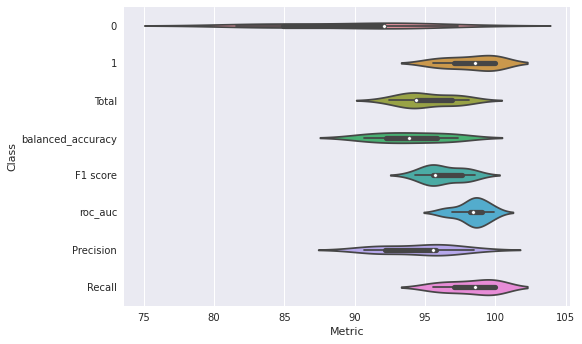

In [55]:
epochs = hp_pca_best_params['epochs']
masks_no = hp_pca_best_params['masks_no']
mask_size = hp_pca_best_params['mask_size']
target_size = hp_pca_best_params['target_size']
n_comp = hp_pca_best_params['n_comp']
data_size = max_size

nn_pca_results = test_model(network_pca_fn(target_size=target_size, mask_size=mask_size, masks_no=masks_no, n_comp=n_comp),
                (X, y),
                data_size,
                None, 10)

# exp.log_table("metrics.csv", nn_pca_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_pca_results.groupby("Class").mean().loc["F1 score"])

In [56]:
res = nn_pca_results[nn_pca_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

245: 95.19 ~ 1.86 (max: 98.11)


### Hypernetwork

In [29]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner

#### Find hyperparams

In [30]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.int(10, 100, multiple_of=10),
    "mask_size": pyhopper.int(2, 20),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(network_hp_fn, param_grid, time="90m")
hp_best_params

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'epochs': 100, 'masks_no': 60, 'mask_size': 11, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5
torch.Size([1, 128])
CTRL+C received. Will terminate once the currently running candidates finished
Will force termination on 2/3 signals
Will force termination on 2/3 signals
Terminate


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e71a78700>
Traceback (most recent call last):
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/

Terminate
Remote process caught exception in objective function: 
Traceback (most recent call last):
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/pyhopper/parallel.py", line 223, in execute
    iter_or_result = objective_function(candidate, **kwargs)
  File "/tmp/ipykernel_4160439/4160485890.py", line 8, in objective
    model_results = test_model(
  File "/tmp/ipykernel_4160439/3090507337.py", line 65, in test_model
    model.fit(X_train, y_train)
  File "/home/z1157095/hypernet-cnn/hypernet/tabular_hypernet/interfaces.py", line 86, in fit
    train_model(
  File "/home/z1157095/hypernet-cnn/hypernet/tabular_hypernet/training_utils.py", line 297, in train_model
    outputs = hypernet(inputs, masks)
  File "/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/z1157095/hypernet-cnn/hypernet/tabular_hypernet/hypernetwork.py", line

ValueError: Pyhopper - Remote process caught exception

#### Train using the best hyperparams

In [30]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
data_size = max_size

hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, verbose=True),
                    (X, y),
                    data_size,
                    None, 10)

iter 1 of 10 X shape (702, 33)
torch.Size([1, 128])


100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


iter 2 of 10 X shape (702, 33)
torch.Size([1, 128])


 40%|████      | 4/10 [00:26<00:39,  6.66s/it]


KeyboardInterrupt: 

In [47]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

596: 100.00 ~ nan, (max: 100.00)


### Random forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
def get_rf(**params):
    random_seed = np.random.randint(1024)
    def _inner():
        return RandomForestClassifier(
            random_state=random_seed,
            **params
        )
    return _inner

#### Find hyperparams

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'n_estimators': 1550, 'max_features': None, 'criterion': 'gini', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1250, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 250, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_features': None, 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 400, 'max_features': None, 'criterion': 'entropy', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 500, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2200, 'max_features': 0.2, 'criterio

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_features': 0.2, 'criterion': 'gini', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2450, 'max_features': None, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2000, 'max_features': None, 'criterion': 'gini', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2250, 'max_features': 0.7, 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1150, 'max_features': 0.5, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1350, 'max_features': 0.5, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2650, 'max_features': 0.7, 'c

params {'n_estimators': 2700, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_features': None, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2200, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2700, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2700, 'max_features': None, 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 2300, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 150, 'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 16}

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_features': None, 'criterion': 'entropy', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 300, 'max_features': None, 'criterion': 'entropy', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_features': 0.7, 'criterion': 'gini', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_features': 0.3, 'cri

iter 5 of 5
params {'n_estimators': 1400, 'max_features': None, 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1600, 'max_features': 0.7, 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1900, 'max_features': None, 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 600, 'max_features': 0.5, 'criterion': 'entropy', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_features': 'sqrt', 'criterion': 'entropy', '

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 100, 'max_features': None, 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 100, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 250, 'max_features': 0.5, 'criterion': 'entropy', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 550, 'max_features': 0.2, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 650, 'max_features': 0.5, '

iter 5 of 5
params {'n_estimators': 800, 'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 850, 'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_features': 0.2, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 750, 'max_features': None, 'criterion': 'gini', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_features': 0.2, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1900, 'max_features': 0.3, 'criterion': 'entropy', 'max_depth': 4}
iter 1 of

iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1050, 'max_features': None, 'criterion': 'entropy', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1000, 'max_features': None, 'criterion': 'entropy', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 700, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 4}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 950, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1100, 'max_features': 0.3, 'criterion': 'en

iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 450, 'max_features': 0.2, 'criterion': 'entropy', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 200, 'max_features': 0.7, 'criterion': 'entropy', 'max_depth': None}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1750, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1900, 'max_features': 0.3, 'criterion': 'entropy', 'max_depth': 2}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 1750, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 16}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 350, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 8}
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
params {'n_estimators': 50, 'max_features': 0.2, 'crit

{'n_estimators': 700, 'max_features': 0.3, 'criterion': 'gini', 'max_depth': 8}

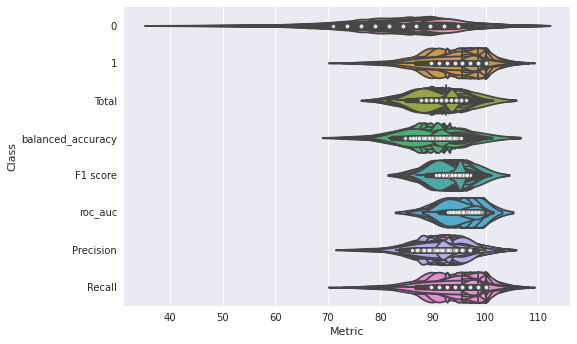

In [63]:
param_grid = {
                'n_estimators': pyhopper.int(50, 3000, multiple_of=50),
                'max_features': pyhopper.choice([None, 'sqrt', 0.2, 0.3, 0.5, 0.7]),
                'criterion' : pyhopper.choice(['gini', 'entropy']),
                'max_depth': pyhopper.choice([None, 2, 4, 8, 16]),
             }

rf_best = pyhopper_best_params(get_rf, param_grid, time="90m")
rf_best

#### Use best params

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10


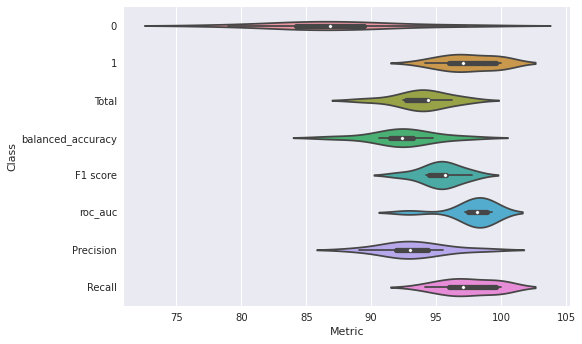

In [64]:
size = max_size

rf_dframe = test_model(get_rf(**rf_best), 
                        (X, y),
                        size,
                        None, iters=10)

In [65]:
res = rf_dframe[rf_dframe["Class"]=="roc_auc"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

245: 97.78 ~ 1.85, (max: 99.30)


# Collect analytics

In [66]:
d = {}

In [67]:
d['Random forest'] = rf_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Hypernet'] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['HypernetPCA'] = nn_pca_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_1'] = nn1_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_2'] = nn2_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_3'] = nn3_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Node'] = node_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['XGBoost'] = xgb_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

In [68]:
all_models_df=pd.concat(d, axis=0)
all_models_df

mean       std         max
              Class                                             
Random forest 0                  87.368421  5.084694   97.368421
              1                  97.500000  2.085495  100.000000
              F1 score           95.333840  1.576103   97.777778
              Precision          93.316425  2.568242   98.507463
              Recall             97.500000  2.085495  100.000000
...                                    ...       ...         ...
XGBoost       Precision          91.474974  2.532562   97.101449
              Recall             97.794118  1.753058  100.000000
              Total              92.688679  2.161592   97.169811
              balanced_accuracy  90.673375  2.756514   96.633127
              roc_auc            96.743421  1.938780   99.303406

[64 rows x 3 columns]

In [ ]:
all_models_df.to_csv(f"{DATA}_metrics.csv")

In [22]:
os.environ['COMET_KEY'] = 'UXrV5UxyhTK3cyQNG6BDuc4bE'

In [23]:
exp = Experiment(os.environ.get("COMET_KEY"), 'hypernet-uci-tune')
# exp.log_parameters({"epochs": epochs, "mask_size": mask_size, "masks_no": masks_no, "data_size": data_size})
exp.add_tag(f"hypernet-tune2{DATA}")

all_models_df.to_csv(f"{DATA}_metrics.csv")
exp.log_table(f"{DATA}_metrics.csv", all_models_df)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/abulenok/hypernet-uci-tune/3a424dd92d6041de84cdd3adfd7ddd8a



{'web': 'https://www.comet.com/api/asset/download?assetId=b2269813d49544f59dd2368caccad02e&experimentKey=3a424dd92d6041de84cdd3adfd7ddd8a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=b2269813d49544f59dd2368caccad02e&experimentKey=3a424dd92d6041de84cdd3adfd7ddd8a',
 'assetId': 'b2269813d49544f59dd2368caccad02e'}

In [72]:
f"{DATA}_metrics.csv"

'Ionosphere_metrics.csv'

In [2]:
import pandas as pd

In [6]:
all_models_df = pd.read_csv(f"{DATA}_metrics.csv")

In [7]:
all_models_df

,Unnamed: 0,Class,mean,std,max
0,Random forest,0,87.368421,5.084694,97.368421
1,Random forest,1,97.500000,2.085495,100.000000
2,Random forest,F1 score,95.333840,1.576103,97.777778
3,Random forest,Precision,93.316425,2.568242,98.507463
4,Random forest,Recall,97.500000,2.085495,100.000000
...,...,...,...,...,...
59,XGBoost,Precision,91.474974,2.532562,97.101449
60,XGBoost,Recall,97.794118,1.753058,100.000000
61,XGBoost,Total,92.688679,2.161592,97.169811
62,XGBoost,balanced_accuracy,90.673375,2.756514,96.633127


In [75]:
tmp = all_models_df.reset_index()

In [76]:
tmp.columns[0]

'level_0'

In [77]:
tmp = tmp.rename(columns={tmp.columns[0]: DATA})

In [78]:
tmp[tmp['Class'] == "balanced_accuracy"]

,Ionosphere,Class,mean,std,max
6,Random forest,balanced_accuracy,92.434211,2.603239,97.213622
14,Hypernet,balanced_accuracy,94.523994,1.468918,96.633127
22,HypernetPCA,balanced_accuracy,93.986068,2.463455,97.368421
30,Dropout_1,balanced_accuracy,85.828173,3.700396,91.369969
38,Dropout_2,balanced_accuracy,92.027864,3.041204,96.052632
46,Dropout_3,balanced_accuracy,93.432663,3.718799,99.264706
54,Node,balanced_accuracy,91.029412,1.789862,93.421053
62,XGBoost,balanced_accuracy,90.673375,2.756514,96.633127


In [79]:
tmp[tmp['Class'] == "roc_auc"]

,Ionosphere,Class,mean,std,max
7,Random forest,roc_auc,97.782508,1.853195,99.303406
15,Hypernet,roc_auc,98.568111,0.818712,99.419505
23,HypernetPCA,roc_auc,98.386223,1.088655,99.883901
31,Dropout_1,roc_auc,94.353715,2.963241,98.606811
39,Dropout_2,roc_auc,98.084365,1.666260,99.342105
47,Dropout_3,roc_auc,97.693498,1.657042,99.922601
55,Node,roc_auc,97.225232,1.444218,98.839009
63,XGBoost,roc_auc,96.743421,1.938780,99.303406
